In [1]:
import os
import sys
# Add src/ to sys.path (relative to current notebook)
sys.path.append(os.path.abspath("../../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import re

from utils.DataAnalysis import TableAnalysis, MyCustomException
from utils.VariableAnalysis import UnivariateAnalysis,BivariateAnalysis
from utils.pdf_file_save import PDFReportWriter

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
file_path = pathlib.Path('D:\Capstone Project\dataset\House_Price_dataset')
df = pd.read_csv(f"{file_path}/4.gurgaon_properties_cleaned_v1.csv")
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,m3m woodshire,sector 107,0.80,5856.0,1366.0,Super Built up area 1366(126.91 sq.m.),2,2,3+,not available,7.0,North-East,1 to 5 Year Old,"['Signum 107', 'Nora Solomon Medicenter', 'Ind...","['2 Wardrobe', '5 Fan', '1 Exhaust Fan', '5 Li...","['Water purifier', 'Security / Fire Alarm', 'F..."
1,flat,not applicable,sector 4,0.42,5600.0,750.0,Carpet area: 750 (69.68 sq.m.),2,2,1,not available,3.0,NaN,1 to 5 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Prat...","['4 Wardrobe', '1 Water Purifier', '2 Fan', '1...","['Lift(s)', 'Water purifier', 'Maintenance Sta..."
2,house,independent,sector 105,0.60,11102.0,540.0,Plot area 60(50.17 sq.m.),8,4,3,not available,3.0,West,0 to 1 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Bhar...","['9 Fan', '17 Light', 'No AC', 'No Bed', 'No C...","['Private Garden / Terrace', 'Park']"
3,flat,kashish manor one,sector 111,1.65,7097.0,2325.0,Super Built up area 2325(216 sq.m.),3,4,3+,"servant room,others",14.0,NaN,Under Construction,"['HUDA Sector 23 Market', 'Palam Vihar Vyapar ...",[],"['Park', 'Club house / Community Center', 'Wat..."
4,house,independent,sector 3,0.90,10000.0,900.0,Plot area 900(83.61 sq.m.)Built Up area: 3500 ...,3,4,3,others,3.0,NaN,5 to 10 Year Old,"['Palam Vihar Vyapar kendra', 'Palam triangle'...","['1 Bed', '5 Wardrobe', '1 Water Purifier', '4...","['Feng Shui / Vaastu Compliant', 'Water Storag..."


In [3]:
df.duplicated().sum()

np.int64(122)

In [4]:
df.head(1)
# focus is on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,m3m woodshire,sector 107,0.8,5856.0,1366.0,Super Built up area 1366(126.91 sq.m.),2,2,3+,not available,7.0,North-East,1 to 5 Year Old,"['Signum 107', 'Nora Solomon Medicenter', 'Ind...","['2 Wardrobe', '5 Fan', '1 Exhaust Fan', '5 Li...","['Water purifier', 'Security / Fire Alarm', 'F..."


## 1. areaWithType

In [5]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
2126,0.38,900.0,Plot area 900(83.61 sq.m.)
2192,9.25,3240.0,Plot area 3240(301.01 sq.m.)Built Up area: 500...
1513,1.80,1704.0,Carpet area: 1704 (158.31 sq.m.)
2199,0.82,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet a...
3479,5.50,1800.0,Plot area 200(167.23 sq.m.)


In [6]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [7]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [8]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [9]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)

df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [10]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
165,0.96,flat,722.0,Super Built up area 1351(125.51 sq.m.)Carpet a...,1351.0,NaN,722.0
673,1.40,flat,1780.0,Super Built up area 1780(165.37 sq.m.),1780.0,NaN,NaN
3797,0.80,flat,1523.0,Carpet area: 1523 (141.49 sq.m.),NaN,NaN,1523.0
2352,0.95,flat,1210.0,Built Up area: 1210 (112.41 sq.m.),NaN,1210.0,NaN
2747,3.98,flat,2200.0,Super Built up area 2200(204.39 sq.m.),2200.0,NaN,NaN


In [11]:
df.duplicated().sum()

np.int64(122)

In [12]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [13]:
## Property type House has Plot Area

df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2,0.6,house,540.0,Plot area 60(50.17 sq.m.),NaN,NaN,NaN
4,0.9,house,900.0,Plot area 900(83.61 sq.m.)Built Up area: 3500 ...,NaN,3500.0,NaN
13,0.4,house,450.0,Plot area 50(41.81 sq.m.),NaN,NaN,NaN
15,3.6,house,1449.0,Plot area 161(134.62 sq.m.),NaN,NaN,NaN
22,4.3,house,1494.0,Plot area 166(138.8 sq.m.)Built Up area: 165 s...,NaN,165.0,164.0
...,...,...,...,...,...,...,...
3776,3.4,house,1530.0,Plot area 170(142.14 sq.m.),NaN,NaN,NaN
3782,8.7,house,2250.0,Plot area 250(209.03 sq.m.)Built Up area: 267 ...,NaN,267.0,NaN
3785,11.5,house,4680.0,Plot area 520(434.79 sq.m.),NaN,NaN,NaN
3793,1.5,house,1350.0,Plot area 150(125.42 sq.m.),NaN,NaN,NaN


In [14]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [15]:
## Nan Value for all newly Created Columns [super_built_up_area,built_up_area,carpet_area]
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [16]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2,0.6,house,540.0,Plot area 60(50.17 sq.m.),NaN,NaN,NaN
13,0.4,house,450.0,Plot area 50(41.81 sq.m.),NaN,NaN,NaN
15,3.6,house,1449.0,Plot area 161(134.62 sq.m.),NaN,NaN,NaN
28,0.5,house,55.0,Plot area 55(5.11 sq.m.),NaN,NaN,NaN
29,0.4,house,432.0,Plot area 432(40.13 sq.m.),NaN,NaN,NaN


In [17]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [18]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [19]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [20]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2,0.6,house,540.0,Plot area 60(50.17 sq.m.),NaN,60.0,NaN
13,0.4,house,450.0,Plot area 50(41.81 sq.m.),NaN,50.0,NaN
15,3.6,house,1449.0,Plot area 161(134.62 sq.m.),NaN,161.0,NaN
28,0.5,house,55.0,Plot area 55(5.11 sq.m.),NaN,55.0,NaN
29,0.4,house,432.0,Plot area 432(40.13 sq.m.),NaN,432.0,NaN


In [21]:
## Recalculating build up Area in to sq FEET  Metric since some areas are given in square yard.

def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [22]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [23]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2,0.6,house,540.0,Plot area 60(50.17 sq.m.),NaN,540.0,NaN
13,0.4,house,450.0,Plot area 50(41.81 sq.m.),NaN,450.0,NaN
15,3.6,house,1449.0,Plot area 161(134.62 sq.m.),NaN,1449.0,NaN
28,0.5,house,55.0,Plot area 55(5.11 sq.m.),NaN,55.0,NaN
29,0.4,house,432.0,Plot area 432(40.13 sq.m.),NaN,432.0,NaN
...,...,...,...,...,...,...,...
3775,2.1,house,900.0,Plot area 900(83.61 sq.m.),NaN,900.0,NaN
3776,3.4,house,1530.0,Plot area 170(142.14 sq.m.),NaN,1530.0,NaN
3785,11.5,house,4680.0,Plot area 520(434.79 sq.m.),NaN,4680.0,NaN
3793,1.5,house,1350.0,Plot area 150(125.42 sq.m.),NaN,1350.0,NaN


In [24]:
# update the original dataframe
df.update(all_nan_df)

In [25]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [26]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,m3m woodshire,sector 107,0.80,5856.0,1366.0,Super Built up area 1366(126.91 sq.m.),2,2,3+,not available,7.0,North-East,1 to 5 Year Old,"['Signum 107', 'Nora Solomon Medicenter', 'Ind...","['2 Wardrobe', '5 Fan', '1 Exhaust Fan', '5 Li...","['Water purifier', 'Security / Fire Alarm', 'F...",1366.0,NaN,NaN
1,flat,not applicable,sector 4,0.42,5600.0,750.0,Carpet area: 750 (69.68 sq.m.),2,2,1,not available,3.0,NaN,1 to 5 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Prat...","['4 Wardrobe', '1 Water Purifier', '2 Fan', '1...","['Lift(s)', 'Water purifier', 'Maintenance Sta...",NaN,NaN,750.0
2,house,independent,sector 105,0.60,11102.0,540.0,Plot area 60(50.17 sq.m.),8,4,3,not available,3.0,West,0 to 1 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Bhar...","['9 Fan', '17 Light', 'No AC', 'No Bed', 'No C...","['Private Garden / Terrace', 'Park']",NaN,540.0,NaN
3,flat,kashish manor one,sector 111,1.65,7097.0,2325.0,Super Built up area 2325(216 sq.m.),3,4,3+,"servant room,others",14.0,NaN,Under Construction,"['HUDA Sector 23 Market', 'Palam Vihar Vyapar ...",[],"['Park', 'Club house / Community Center', 'Wat...",2325.0,NaN,NaN
4,house,independent,sector 3,0.90,10000.0,900.0,Plot area 900(83.61 sq.m.)Built Up area: 3500 ...,3,4,3,others,3.0,NaN,5 to 10 Year Old,"['Palam Vihar Vyapar kendra', 'Palam triangle'...","['1 Bed', '5 Wardrobe', '1 Water Purifier', '4...","['Feng Shui / Vaastu Compliant', 'Water Storag...",NaN,3500.0,NaN


## 2.additionalRoom

In [27]:
df['additionalRoom'].value_counts()

additionalRoom
not available                         1587
servant room                           705
study room                             250
others                                 225
pooja room                             165
                                      ... 
others,study room                        1
store room,study room,servant room       1
study room,others,servant room           1
study room,store room,pooja room         1
store room,servant room,pooja room       1
Name: count, Length: 65, dtype: int64

In [28]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [29]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
24,"pooja room,study room,servant room,others",1,1,0,1,1
183,not available,0,0,0,0,0
2070,not available,0,0,0,0,0
1602,others,0,0,0,0,1
2840,servant room,0,1,0,0,0


In [30]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,m3m woodshire,sector 107,0.80,5856.0,1366.0,Super Built up area 1366(126.91 sq.m.),2,2,3+,not available,7.0,North-East,1 to 5 Year Old,"['Signum 107', 'Nora Solomon Medicenter', 'Ind...","['2 Wardrobe', '5 Fan', '1 Exhaust Fan', '5 Li...","['Water purifier', 'Security / Fire Alarm', 'F...",1366.0,NaN,NaN,0,0,0,0,0
1,flat,not applicable,sector 4,0.42,5600.0,750.0,Carpet area: 750 (69.68 sq.m.),2,2,1,not available,3.0,NaN,1 to 5 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Prat...","['4 Wardrobe', '1 Water Purifier', '2 Fan', '1...","['Lift(s)', 'Water purifier', 'Maintenance Sta...",NaN,NaN,750.0,0,0,0,0,0
2,house,independent,sector 105,0.60,11102.0,540.0,Plot area 60(50.17 sq.m.),8,4,3,not available,3.0,West,0 to 1 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Bhar...","['9 Fan', '17 Light', 'No AC', 'No Bed', 'No C...","['Private Garden / Terrace', 'Park']",NaN,540.0,NaN,0,0,0,0,0
3,flat,kashish manor one,sector 111,1.65,7097.0,2325.0,Super Built up area 2325(216 sq.m.),3,4,3+,"servant room,others",14.0,NaN,Under Construction,"['HUDA Sector 23 Market', 'Palam Vihar Vyapar ...",[],"['Park', 'Club house / Community Center', 'Wat...",2325.0,NaN,NaN,0,1,0,0,1
4,house,independent,sector 3,0.90,10000.0,900.0,Plot area 900(83.61 sq.m.)Built Up area: 3500 ...,3,4,3,others,3.0,NaN,5 to 10 Year Old,"['Palam Vihar Vyapar kendra', 'Palam triangle'...","['1 Bed', '5 Wardrobe', '1 Water Purifier', '4...","['Feng Shui / Vaastu Compliant', 'Water Storag...",NaN,3500.0,NaN,0,0,0,0,1


## 3.agePossession

In [31]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Aug 2023                 7
Dec 2025                 7
Jun 2024                 7
Nov 2023                 5
By 2025                  4
Jul 2024                 4
Oct 2023                 4
Aug 2024                 4
Sep 2023                 4
May 2024                 3
Feb 2024                 3
Nov 2024                 3
Jan 2025                 3
By 2027                  2
Apr 2026                 2
Dec 2026                 2
Aug 2025                 2
Sep 2025                 2
Mar 2025                 2
Jul 2025                 2
Jul 2027                 2
Jan 2026      

In [32]:
## categorical valu of agePossesion Binning in to category 

def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [33]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [34]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

In [35]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,m3m woodshire,sector 107,0.80,5856.0,1366.0,Super Built up area 1366(126.91 sq.m.),2,2,3+,not available,7.0,North-East,Relatively New,"['Signum 107', 'Nora Solomon Medicenter', 'Ind...","['2 Wardrobe', '5 Fan', '1 Exhaust Fan', '5 Li...","['Water purifier', 'Security / Fire Alarm', 'F...",1366.0,NaN,NaN,0,0,0,0,0
1,flat,not applicable,sector 4,0.42,5600.0,750.0,Carpet area: 750 (69.68 sq.m.),2,2,1,not available,3.0,NaN,Relatively New,"['Chintapurni Mandir', 'State bank ATM', 'Prat...","['4 Wardrobe', '1 Water Purifier', '2 Fan', '1...","['Lift(s)', 'Water purifier', 'Maintenance Sta...",NaN,NaN,750.0,0,0,0,0,0
2,house,independent,sector 105,0.60,11102.0,540.0,Plot area 60(50.17 sq.m.),8,4,3,not available,3.0,West,New Property,"['Chintapurni Mandir', 'State bank ATM', 'Bhar...","['9 Fan', '17 Light', 'No AC', 'No Bed', 'No C...","['Private Garden / Terrace', 'Park']",NaN,540.0,NaN,0,0,0,0,0
3,flat,kashish manor one,sector 111,1.65,7097.0,2325.0,Super Built up area 2325(216 sq.m.),3,4,3+,"servant room,others",14.0,NaN,Under Construction,"['HUDA Sector 23 Market', 'Palam Vihar Vyapar ...",[],"['Park', 'Club house / Community Center', 'Wat...",2325.0,NaN,NaN,0,1,0,0,1
4,house,independent,sector 3,0.90,10000.0,900.0,Plot area 900(83.61 sq.m.)Built Up area: 3500 ...,3,4,3,others,3.0,NaN,Moderately Old,"['Palam Vihar Vyapar kendra', 'Palam triangle'...","['1 Bed', '5 Wardrobe', '1 Water Purifier', '4...","['Feng Shui / Vaastu Compliant', 'Water Storag...",NaN,3500.0,NaN,0,0,0,0,1


## 4.furnishDetails

In [36]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
195,NaN,"['Security / Fire Alarm', 'Intercom Facility',..."
83,"['16 Wardrobe', '26 Fan', '1 Exhaust Fan', '16...","['High Ceiling Height', 'Park', 'Visitor Parki..."
107,"['1 Water Purifier', '4 Fan', '1 Fridge', '1 E...","['Security / Fire Alarm', 'Lift(s)', 'Maintena..."
3254,"['22 Wardrobe', '24 Fan', '1 Exhaust Fan', '33...","['Feng Shui / Vaastu Compliant', 'Private Gard..."
2147,NaN,['Maintenance Staff']


In [37]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [38]:
furnishings_df.shape

(3803, 19)

In [39]:
furnishings_df.sample(5)

,furnishDetails,Fridge,Microwave,Sofa,Stove,Dining Table,Fan,Geyser,Light,Bed,Wardrobe,AC,Chimney,Curtains,Modular Kitchen,Exhaust Fan,TV,Washing Machine,Water Purifier
2307,"['4 Fan', '1 Exhaust Fan', '10 Light', '2 AC',...",0,0,0,0,0,4,0,10,0,0,2,0,0,1,1,0,0,0
3537,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3286,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
524,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2557,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)
furnishings_df.sample(5)

,Fridge,Microwave,Sofa,Stove,Dining Table,Fan,Geyser,Light,Bed,Wardrobe,AC,Chimney,Curtains,Modular Kitchen,Exhaust Fan,TV,Washing Machine,Water Purifier
719,0,0,0,0,0,5,1,4,0,2,0,1,0,0,1,0,0,0
773,0,0,0,1,0,6,0,11,0,3,4,1,0,1,1,0,0,0
1239,0,1,0,1,0,7,5,35,0,6,5,1,10,1,1,0,0,1
3246,0,0,0,0,0,3,0,30,0,3,0,1,1,1,1,0,0,0
2420,0,0,0,0,0,3,0,3,0,0,0,0,0,0,1,0,0,0


In [41]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [42]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [43]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

  File "c:\Users\mayal\anaconda3\envs\ds_generic\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\mayal\anaconda3\envs\ds_generic\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\mayal\anaconda3\envs\ds_generic\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\mayal\anaconda3\envs\ds_generic\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


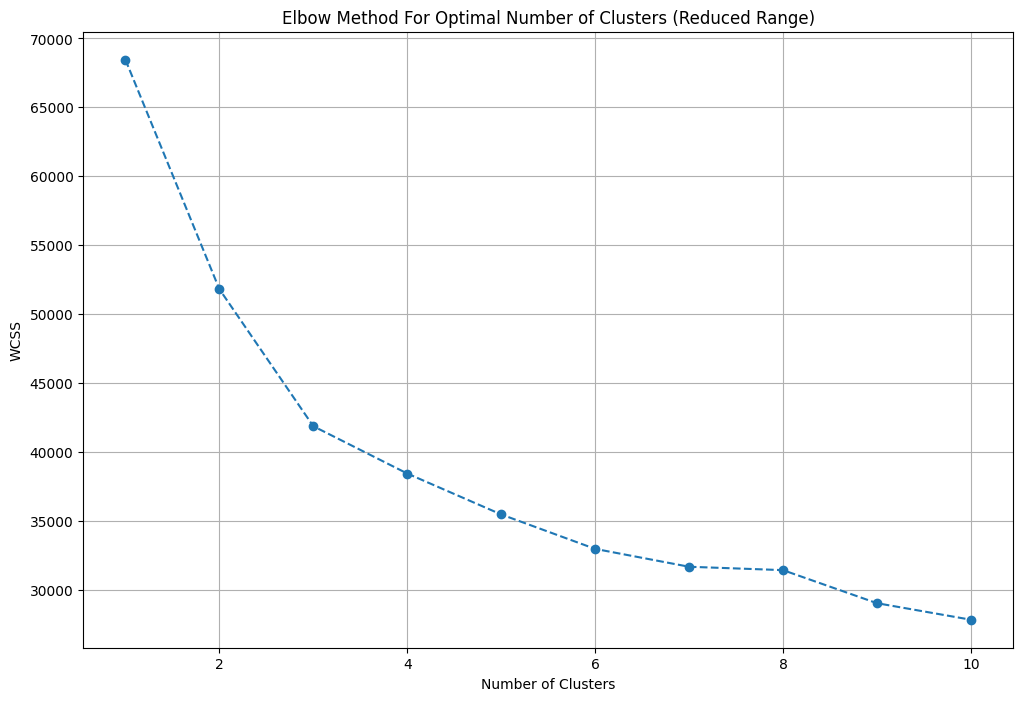

In [44]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [45]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [46]:
df = df.iloc[:,:-18]

In [47]:
df['furnishing_type'] = cluster_assignments

In [48]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
937,"['1 Water Purifier', '10 Fan', '1 Exhaust Fan'...",2
2588,"['11 Fan', '1 Exhaust Fan', '55 Light', '9 AC'...",1
2135,NaN,0
2640,"['5 Wardrobe', '10 Fan', '1 Exhaust Fan', '6 G...",1
1171,NaN,0


## 5.features

In [49]:
df[['society','features']].sample(5)

,society,features
1431,independent,NaN
3250,dlf city plots,"['Feng Shui / Vaastu Compliant', 'Private Gard..."
2616,corona optus,"['Lift(s)', 'Maintenance Staff', 'Water Storag..."
1068,emaar mgf the enclave,"['Centrally Air Conditioned', 'Water purifier'..."
2670,independent,"['Feng Shui / Vaastu Compliant', 'Recently Ren..."


In [50]:
df['features'].isnull().sum()

np.int64(635)

In [51]:
import pandas as pd
app_df = pd.read_csv(f'{file_path}/appartments.csv')
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Pa...","{'Bajghera Road': '800 Meter', 'Palam Vihar Ha...",https://www.99acres.com/smartworld-one-dxp-sec...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Salon', 'Restaurant', 'Spa'..."
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap Un...","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The N...",https://www.99acres.com/m3m-crown-sector-111-g...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Bowling Alley', 'Mini Theatre', 'Manicured G..."


In [52]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [53]:
temp_df = df[df['features'].isnull()]

In [54]:
temp_df.shape

(635, 26)

In [55]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [56]:
df.loc[temp_df.index,'features'] = x.values

In [57]:
df['features'].isnull().sum()

np.int64(481)

In [58]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [59]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [60]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1213,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
features_binary_df.shape

(3803, 130)

In [62]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

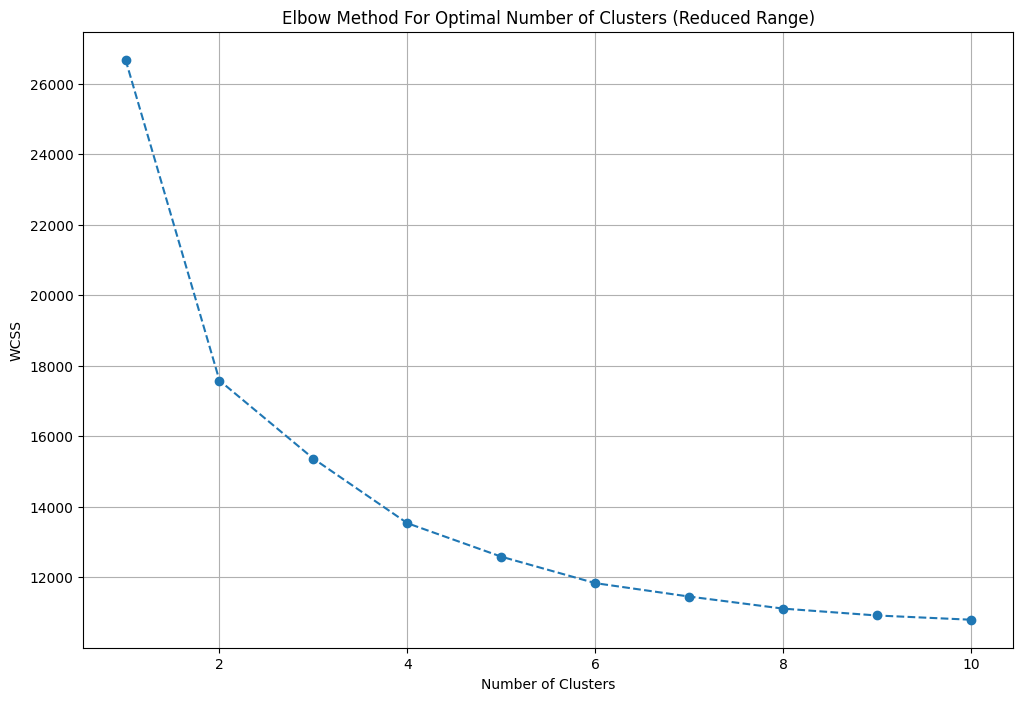

In [63]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [64]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [65]:
df['luxury_score'] = luxury_score

In [66]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,m3m woodshire,sector 107,0.80,5856.0,1366.0,Super Built up area 1366(126.91 sq.m.),2,2,3+,not available,7.0,North-East,Relatively New,"['Signum 107', 'Nora Solomon Medicenter', 'Ind...","['2 Wardrobe', '5 Fan', '1 Exhaust Fan', '5 Li...","['Water purifier', 'Security / Fire Alarm', 'F...",1366.0,NaN,NaN,0,0,0,0,0,1,"[Water purifier, Security / Fire Alarm, Feng S...",165
1,flat,not applicable,sector 4,0.42,5600.0,750.0,Carpet area: 750 (69.68 sq.m.),2,2,1,not available,3.0,NaN,Relatively New,"['Chintapurni Mandir', 'State bank ATM', 'Prat...","['4 Wardrobe', '1 Water Purifier', '2 Fan', '1...","['Lift(s)', 'Water purifier', 'Maintenance Sta...",NaN,NaN,750.0,0,0,0,0,0,1,"[Lift(s), Water purifier, Maintenance Staff, F...",26
2,house,independent,sector 105,0.60,11102.0,540.0,Plot area 60(50.17 sq.m.),8,4,3,not available,3.0,West,New Property,"['Chintapurni Mandir', 'State bank ATM', 'Bhar...","['9 Fan', '17 Light', 'No AC', 'No Bed', 'No C...","['Private Garden / Terrace', 'Park']",NaN,540.0,NaN,0,0,0,0,0,0,"[Private Garden / Terrace, Park]",17
3,flat,kashish manor one,sector 111,1.65,7097.0,2325.0,Super Built up area 2325(216 sq.m.),3,4,3+,"servant room,others",14.0,NaN,Under Construction,"['HUDA Sector 23 Market', 'Palam Vihar Vyapar ...",[],"['Park', 'Club house / Community Center', 'Wat...",2325.0,NaN,NaN,0,1,0,0,1,0,"[Park, Club house / Community Center, Water so...",8
4,house,independent,sector 3,0.90,10000.0,900.0,Plot area 900(83.61 sq.m.)Built Up area: 3500 ...,3,4,3,others,3.0,NaN,Moderately Old,"['Palam Vihar Vyapar kendra', 'Palam triangle'...","['1 Bed', '5 Wardrobe', '1 Water Purifier', '4...","['Feng Shui / Vaastu Compliant', 'Water Storag...",NaN,3500.0,NaN,0,0,0,0,1,1,"[Feng Shui / Vaastu Compliant, Water Storage, ...",42


In [67]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [68]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
613,flat,tata primanti,sector 72,4.10,13725.0,2987.0,Super Built up area 2550(236.9 sq.m.),3,3,3,8.0,NaN,Moderately Old,2550.0,NaN,NaN,0,1,0,0,0,0,38
2119,flat,indiabulls enigma,sector 110,3.70,10882.0,3400.0,Super Built up area 3400(315.87 sq.m.),4,5,3,7.0,South-West,Relatively New,3400.0,NaN,NaN,0,1,0,0,0,0,156
1723,flat,bestech park view sanskruti,sector 92,1.55,7568.0,2048.0,Super Built up area 1995(185.34 sq.m.),3,4,3,16.0,South,Relatively New,1995.0,NaN,NaN,0,1,0,0,0,1,60
289,flat,bptp terra,sector 37d,2.08,10000.0,2080.0,Super Built up area 2443(226.96 sq.m.),4,4,3,0.0,North-East,New Property,2443.0,NaN,NaN,1,1,0,1,0,0,121
1099,flat,signature global synera,sector 81,0.50,6802.0,735.0,Super Built up area 735(68.28 sq.m.)Built Up a...,2,2,3,6.0,South,Relatively New,735.0,700.0,635.0,0,0,0,0,0,0,117


In [69]:
df.shape

(3803, 23)

In [70]:
df.iloc[1254:]

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1254,flat,signature global park,sohna road,0.87,7190.0,1210.0,Built Up area: 1210 (112.41 sq.m.)Carpet area:...,3,2,3,4.0,NaN,Undefined,NaN,1210.0,870.0,0,0,0,0,0,0,58
1255,flat,dlf new town heights,sector 86,1.30,6735.0,1930.0,Super Built up area 1930(179.3 sq.m.),3,3,3,12.0,West,Moderately Old,1930.0,NaN,NaN,0,1,0,1,0,0,106
1256,flat,signature global park,sohna road,0.58,7056.0,822.0,Built Up area: 822 (76.37 sq.m.)Carpet area: 6...,2,2,2,3.0,NaN,Undefined,NaN,822.0,600.0,0,0,0,0,0,0,58
1257,flat,tulip violet,sector 69,1.30,8445.0,1539.0,Super Built up area 1538(142.88 sq.m.),3,3,1,12.0,West,Relatively New,1538.0,NaN,NaN,0,0,0,1,0,1,94
1258,house,ansals florence villa,sector 57,3.65,10579.0,3450.0,Plot area 3450(320.52 sq.m.),6,6,2,3.0,North-West,Moderately Old,NaN,3450.0,NaN,1,1,1,1,0,2,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3798,house,independent,sector 26,20.00,44444.0,4500.0,Plot area 500(418.06 sq.m.),5,7,3+,3.0,West,Relatively New,NaN,4500.0,NaN,0,1,0,1,0,2,97
3799,flat,umang monsoon breeze,sector 78,0.90,4615.0,1950.0,Super Built up area 1950(181.16 sq.m.)Built Up...,3,3,2,1.0,NaN,Moderately Old,1950.0,1900.0,1854.0,0,1,0,1,0,0,65
3800,flat,sapphire eighty three,sector 83,0.65,9286.0,700.0,Built Up area: 700 (65.03 sq.m.),1,1,0,6.0,NaN,Undefined,NaN,700.0,NaN,0,0,0,0,0,0,0
3801,flat,shapoorji pallonji joyville gurugram,sector 102,1.20,14563.0,824.0,Super Built up area 1359(126.26 sq.m.)Carpet a...,2,2,3,0.0,North-East,Relatively New,1359.0,NaN,824.0,0,0,0,0,0,0,49


In [71]:
df.to_csv(f'{file_path}/5.gurgaon_properties_cleaned_v2.csv',index=False)